# This notebook is under construction. 

- In this notebook a rather simple 1-D CNN is trained and tested on H-alpha diagnostics. 
- Later this 1-D CNN may be used as a supplementary model for the ensembled RIS1xRIS2 resp. RIS1xRIS1 model, which have poor performance in distinguishing H-modes from ELMs.


- Functions written here will migrate to `confinement_mode_classifier.py` once tested

In [1]:
import os
from pathlib import Path
import re
import torch
from tqdm.notebook import tqdm
from torch.optim import lr_scheduler
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time 
from datetime import datetime
import alt_models as am
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
path = Path(os.getcwd())
data_dir_path = f'{path}/data/LP_MC_H_alpha'
file_names = os.listdir(data_dir_path)

#What signal to use
signal_name = 'h_alpha'
signal_window = 160

batch_size = 512

#Shots used in training
shot_numbers = [re.search(r'shot_(\d+)', file_name).group(1) for file_name in file_names]
removed_shots = ['17848']
shot_numbers = [valid_shot for valid_shot in shot_numbers if valid_shot not in removed_shots]

#Shots used for testing and validation
shots_for_testing = ['18130', '16773', '16534', 
                     '19094', '18133', '17837', 
                     '18128', '19915', '19925', 
                     '13182', '20009', '20112']

shots_for_validation = ['16769', '19379', '18057', 
                        '18132', '18261', '18267', 
                        '18260', '20143', '20145', 
                        '20146', '20147', '20144', 
                        '20098']


shot_df, test_df, val_df, train_df = am.split_df(path, shot_numbers, shots_for_testing, shots_for_validation, use_ELMS=True)


In [3]:
train_dataloader = am.get_dloader(train_df, batch_size=batch_size, 
                               balance_data=True, shuffle=False, 
                               signal_window=signal_window,
                               signal_name=signal_name,
                               num_workers=8)

val_dataloader = am.get_dloader(val_df, batch_size=batch_size, 
                             balance_data=False, shuffle=False, 
                             signal_window=signal_window,
                             signal_name=signal_name,
                             num_workers=8)

test_dataloader = am.get_dloader(test_df, batch_size=batch_size, 
                              balance_data=False, shuffle=False, 
                              signal_window=signal_window,
                              signal_name=signal_name,
                              num_workers=8)

dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

In [4]:
timestamp =  datetime.fromtimestamp(time.time()).strftime("%y-%m-%d, %H-%M-%S ") + input('add comment: ')
# create grid of images
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{timestamp}')
model_path = Path(f'{path}/runs/{timestamp}/model.pt')

In [5]:
untrained_cnn = am.Simple1DCNN(window=signal_window)
untrained_cnn = untrained_cnn.to(device)

In [6]:
sample_input = next(iter(train_dataloader))[f'{signal_name}'].to(device).float()
writer.add_graph(untrained_cnn, sample_input)

In [7]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(untrained_cnn.parameters(), lr=1e-3) #pouzit adam

exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, total_steps=50) #!!!

num_epochs = 4
trained_cnn = am.train_model(untrained_cnn, criterion, optimizer, exp_lr_scheduler, 
                       dataloaders, writer, dataset_sizes, num_epochs=num_epochs, 
                       chkpt_path = model_path.with_name(f'{model_path.stem}_chkpt{model_path.suffix}'),
                       signal_name=signal_name)

torch.save(trained_cnn.state_dict(), model_path)

Epoch 1/4
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.5652 Acc: 0.7527


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 0.7283 Acc: 0.6917
Epoch 2/4
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.5179 Acc: 0.7783


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 0.7119 Acc: 0.6819
Epoch 3/4
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.5077 Acc: 0.7840


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 0.6703 Acc: 0.7340
Epoch 4/4
----------


  0%|          | 0/2455 [00:00<?, ?it/s]

train Loss: 0.5027 Acc: 0.7869


  0%|          | 0/1180 [00:00<?, ?it/s]

val Loss: 0.6428 Acc: 0.7144
Training complete in 3m 58s
Best val Acc: 0.734042


- Again, `test_model()` is modified function from `cmc` 
- Again main difference is how the batch is processed

Processing batches:   0%|          | 0/1079 [00:00<?, ?it/s]

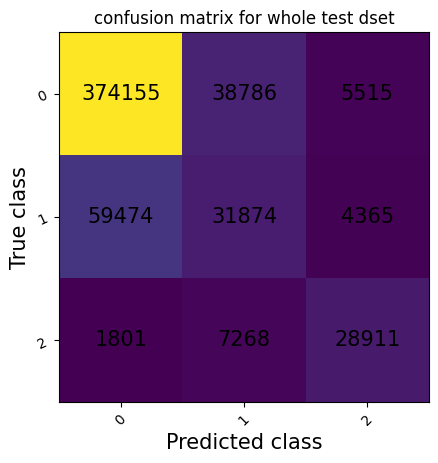

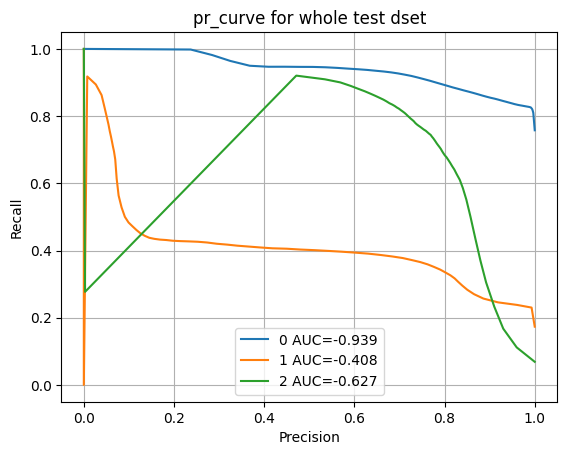

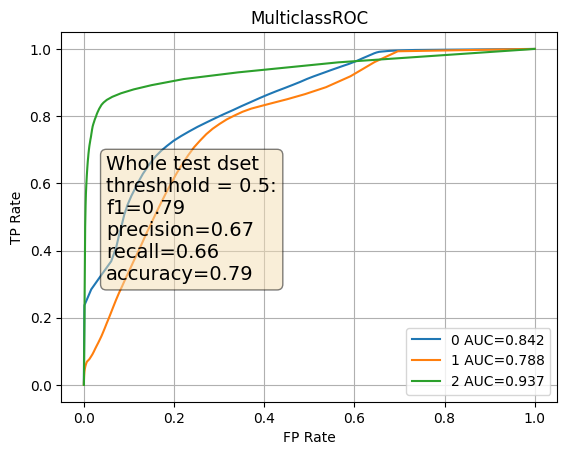

In [8]:
metrics = am.test_model(f'{path}/runs/{timestamp}', trained_cnn, test_dataloader, comment ='3 classes', signal_name=signal_name)

In [9]:
am.per_shot_test(f'{path}/runs/{timestamp}', shots_for_testing, metrics[0])

  0%|          | 0/12 [00:00<?, ?it/s]

/compass/Shared/Users/bogdanov/.venv/lib/python3.8/site-packages/torchmetrics/utilities/plot.py:245: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(nrows=rows, ncols=cols) if ax is None else (ax.get_figure(), ax)


'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/24-02-22, 16-43-40 CNN_on_h_alpha_160dpoints_4epochs/data'